In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import camb
import pandas as pd

from torch.utils.data import Dataset, DataLoader

In [2]:
from transfer_func_models.GA_toolkit import *
from transfer_func_models.gradient_descent_toolkit import *

In [3]:
df = pd.read_csv('camb_transfer_data.txt', header = None)
df = df[0].str.split(" ", n=3, expand=True)

def check_fitting_error(kh, f):
    N = len(kh)
    sum = 0
    for i in range(N):
        sum += np.abs((f(kh[i]) - delta[i])/delta[i])
    return sum*100/N

In [4]:
obh2vals = np.linspace(0.0214, 0.0234, 4)
omh2vals = np.linspace(0.13, 0.15, 4)

k1 = 0
k2 = 2

ombh2 = obh2vals[k1]
ommh2 = omh2vals[k2]
omch2 = ommh2 - ombh2

H0_=67.5
h = (H0_/100)

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0_, ombh2 = ombh2, omch2 = ommh2 - ombh2)
pars.WantTransfer = True
pars.set_matter_power(redshifts=[0], kmax=10)

data = camb.get_transfer_functions(pars)
transfer = data.get_matter_transfer_data()
kh = transfer.transfer_data[0,:,0]
delta = transfer.transfer_data[6,:,0]
delta = delta/delta[0] #normalize


densities = data.get_background_densities(1.)
rho_gamma = densities['photon'][0]
rho_r = densities['photon'][0]# + densities['neutrino'][0] # what else is included in radiation ?



def q_k(k):                               # Eq (6a)
    #k = kh*h
    theta = rho_r/(1.68*rho_gamma)        # Eq (6b)
    return k*(theta**(0.5))/(omch2) 

def BBKS(k):
    q = q_k(k)
    val = 1+3.89*q+(16.1*q)**2+(5.46*q)**3 + (6.71*q)**4
    val = val**(-0.25)
    factor = np.log(1+2.34*q)/(2.34*q)
    return factor*val

def GA_transfer(k):
    # k [h/Mpc]
    x = k/(omch2)
    val = 1+59.0998*x**(1.49177) + 4658.01*x**(4.02755) + 3170.79*x**(6.06) + 150.089*x**(7.28478)
    return val**(-0.25)




def GA_transfer_wiggled(a_s, c_s):
    # k [h/Mpc]
    
    
    def GA_transfer_wiggled_set_params(k):
        s_GA = ( c_s[0]*(ombh2**c_s[1]) + c_s[2]*(ommh2**c_s[3]) + c_s[4]*(ombh2**c_s[5])*(ommh2**c_s[6]) )**(-1)
        k_silk = 1.6*(ombh2**0.52)*(ommh2**0.73)*(1 + (10.4*ommh2)**(-0.95))

        f_a = a_s[7] + a_s[8]*(ombh2**a_s[9]) + a_s[10]*(ommh2**a_s[11])
        f_b = a_s[12] + a_s[13]*(ombh2**a_s[14]) + a_s[15]*(ommh2**a_s[16])
        f_node = a_s[17]*(ommh2**a_s[18])

        val = np.exp(-(k/k_silk)**a_s[2])
        val *= f_a/(a_s[0]+(f_b/(k*s_GA))**a_s[1])
        val *= np.sin(a_s[3]*k*s_GA/(a_s[4]+(f_node/(k*s_GA)**a_s[5]))**a_s[6])
        val += 1
        val *= GA_transfer(k)
        return val
    
    return GA_transfer_wiggled_set_params

def total_error(ks, fit, upto = -1):
    val = 0
    
    if upto != -1:
        len_k = min(len(ks), upto)
    else:
        len_k = len(ks)
    
    for i in range(len_k):
        val += np.abs(fit(ks[i]) - delta[i])*100/(len_k*delta[i])
    
    return val

BBKS FORMULA       avg ERROR: 4.272871889603545
PAPER GA           avg ERROR: 0.6279093360472586
PAPER GA (WIGGLED) avg ERROR: 0.4861599089579974


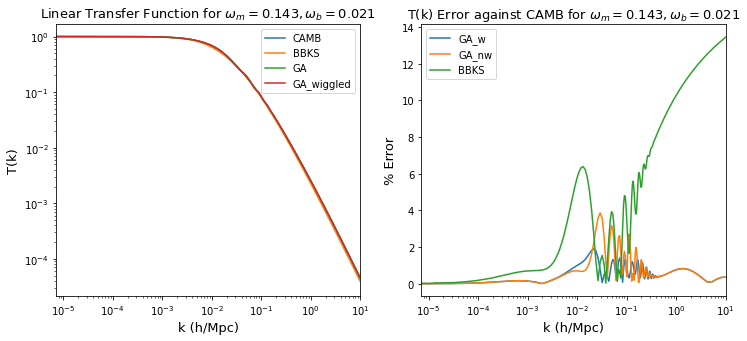

In [5]:
paper_a_s = [1.43679, 2.86538, 0.949946, 0.746495, 1.2384, 3.49433, 0.311833, 0.19012, 0.233442, 0.614879, 0.0532925, 1.38231, 1.34703, 31.7525, 1.22438, 57.7364, 1.04748, 0.102231, 0.999364]
paper_c_s = [0.00785436, 0.177084, 0.00912388, 0.618711, 11.9611, 2.81343, 0.784719]

fig,axs = plt.subplots(1,2, figsize=(12,5), sharex=True)
axs[0].loglog(kh*h, delta, label = 'CAMB')
axs[0].loglog(kh*h, BBKS(kh), label = 'BBKS')
axs[0].loglog(kh*h, GA_transfer(kh), label = 'GA')
axs[0].loglog(kh*h, GA_transfer_wiggled(paper_a_s, paper_c_s)(kh), label = 'GA_wiggled')

axs[0].legend()
axs[0].set_title(f"Linear Transfer Function for $\omega_m = {round(ommh2, 3)}, \omega_b = {round(ombh2, 3)}$", fontsize=13)
axs[0].set_xlabel("k (h/Mpc)", fontsize=13)
axs[0].set_ylabel("T(k)", fontsize=13)


axs[1].semilogx(kh*h, 100*np.abs(GA_transfer_wiggled(paper_a_s, paper_c_s)(kh) - delta)/delta, label = 'GA_w')
axs[1].semilogx(kh*h, 100*np.abs(GA_transfer(kh) - delta)/delta, label = 'GA_nw')
axs[1].semilogx(kh*h, 100*np.abs(BBKS(kh) - delta)/delta, label = 'BBKS')

axs[1].set_xlim(kh[0]*h,10e0)
#axs.set_ylim(10e-2, 10e-1)
axs[1].legend()
axs[1].set_title(f"T(k) Error against CAMB for $\omega_m = {round(ommh2, 3)}, \omega_b = {round(ombh2, 3)}$", fontsize=13)
axs[1].set_xlabel("k (h/Mpc)", fontsize=13)
axs[1].set_ylabel("% Error", fontsize=13)

print("BBKS FORMULA       avg ERROR:", total_error(kh, BBKS))
print("PAPER GA           avg ERROR:", total_error(kh, GA_transfer))
print("PAPER GA (WIGGLED) avg ERROR:", total_error(kh, GA_transfer_wiggled(paper_a_s, paper_c_s)))

In [7]:
# RUNNING THE GA

GA_run_params = np.zeros(26)

test_ranges = np.array([[0, 10], [0, 4], [0, 4], [0, 10], [0, 10], [0, 4], [0, 4], [0, 10], [0, 10], [0, 4], [0, 10], [0, 4], [0, 10], [0, 100], [0, 4], [0, 100], [0, 4], [0, 10], [0, 4], [0, 10], [0, 4], [0, 10], [0, 4], [0, 20], [0, 4], [0, 4]])

# you can tweak these numbers as you wish
config = {"mutation_rate":0.4, "generations":100, "population":20, "camb_data_fname":"camb_transfer_data.txt", "ranges": test_ranges}
sr = geneticAlgorithm(config)
sr.run_algorithm()

best_func = sr.best_fit_func
    
GA_run_params = best_func.params


Initializing random initial population...
Starting genetic algorithm...
Generation: 1
Most fit: 0.7846784796422922
Generation: 11
Most fit: 0.7332409977308546
Generation: 21
Most fit: 0.5676468701865837
Generation: 31
Most fit: 0.5585241008114021
Generation: 41
Most fit: 0.5452461352027504
Generation: 51
Most fit: 0.5449803644681813
Generation: 61
Most fit: 0.5449293032768147
Generation: 71
Most fit: 0.5449236976042237
Generation: 81
Most fit: 0.5449236976042237
Generation: 91
Most fit: 0.5449236976042237


In [8]:
# GRADIENT DESCENT MODEL
# I've determined that gradient descent is not that helpful when wanting a fixed functional form!

do_grad_desc = False

if do_grad_desc:

    train, val = get_data_sets("camb_transfer_data.txt", 0.8)

    train_loader = DataLoader(train, batch_size=512, shuffle=True)
    val_loader   = DataLoader(val, batch_size=512, shuffle=True)

    test_ranges = torch.tensor([[0, 10], [0, 4], [0, 4], [0, 10], [0, 10], [0, 4], [0, 4], [0, 10], [0, 10], [0, 4], [0, 10], [0, 4], [0, 10], [0, 100], [0, 4], [0, 100], [0, 4], [0, 10], [0, 4], [0, 10], [0, 4], [0, 10], [0, 4], [0, 20], [0, 4], [0, 4]])
    test_ranges = torch.transpose(test_ranges, 0, 1)
    model = transferFunctionModel(n_params = 26, init_pars_ranges = test_ranges)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-5)
    loss = loss_fn

    training_loop(250, model, train_loader, loss, optimizer)
    
    grad_desc_params = model.params.data.numpy()

In [9]:
load_from_file = False

if load_from_file:
    
    fname = "ten_GA_runs.txt"
    
    ten_GA_runs_params = np.loadtxt(fname)

    ten_errors = np.zeros(ten_GA_runs_params.shape[0])

    for i in range(len(ten_errors)):
        ten_errors[i] = total_error(kh, GA_transfer_wiggled(ten_GA_runs_params[i, :19], ten_GA_runs_params[i, 19:]))

    # TOP 4 FUNCTIONS
    top_func = np.argsort(ten_errors)[0]
    GA_run_params = ten_ga_runs_params[top_func, :]

GA (MINE)         avg ERROR: 0.6279093360472586
GA (PAPER)        avg ERROR: 1.3092642248987887


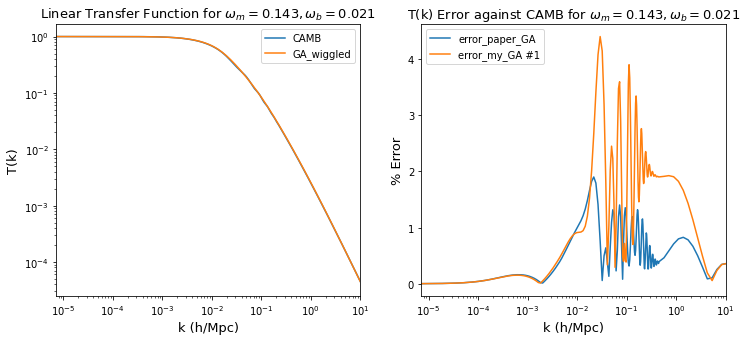

In [11]:

fig,axs = plt.subplots(1,2, figsize=(12,5), sharex=True)
axs[0].loglog(kh*h, delta, label = 'CAMB')
#axs[0].loglog(kh*h, BBKS(kh), label = 'BBKS')
#axs[0].loglog(kh*h, GA_transfer(kh), label = 'GA')

axs[0].loglog(kh*h, GA_transfer_wiggled(GA_run_params[:19], GA_run_params[19:])(kh), label = f'GA_wiggled')
if do_grad_desc:
    axs[0].loglog(kh*h, GA_transfer_wiggled(grad_desc_params[:19], grad_desc_params[19:])(kh), label = f'GradDesc')

axs[0].legend()
axs[0].set_title(f"Linear Transfer Function for $\omega_m = {round(ommh2, 3)}, \omega_b = {round(ombh2, 3)}$", fontsize=13)
axs[0].set_xlabel("k (h/Mpc)", fontsize=13)
axs[0].set_ylabel("T(k)", fontsize=13)


axs[1].semilogx(kh*h, 100*np.abs(GA_transfer_wiggled(paper_a_s, paper_c_s)(kh) - delta)/delta, label = 'error_paper_GA')

for i in range(1):
    axs[1].semilogx(kh*h, 100*np.abs(GA_transfer_wiggled(GA_run_params[:19], GA_run_params[19:])(kh) - delta)/delta, label = f'error_my_GA #{i + 1}')

if do_grad_desc:
    axs[1].semilogx(kh*h, 100*np.abs(GA_transfer_wiggled(grad_desc_params[:19], grad_desc_params[19:])(kh) - delta)/delta, label = 'error_GradDesc')

axs[1].set_xlim(kh[0]*h,10e0)
#axs.set_ylim(10e-2, 10e-1)
axs[1].legend()
axs[1].set_title(f"T(k) Error against CAMB for $\omega_m = {round(ommh2, 3)}, \omega_b = {round(ombh2, 3)}$", fontsize=13)
axs[1].set_xlabel("k (h/Mpc)", fontsize=13)
axs[1].set_ylabel("% Error", fontsize=13)

print("GA (MINE)         avg ERROR:", total_error(kh, GA_transfer))
print("GA (PAPER)        avg ERROR:", total_error(kh, GA_transfer_wiggled(GA_run_params[:19], GA_run_params[19:])))

if do_grad_desc:
    print("Gradient Descent  avg ERROR:", total_error(kh, GA_transfer_wiggled(grad_desc_params[:19], grad_desc_params[19:])))
